In [1]:
# import the python modules that we will use
import psi4
%matplotlib inline
import matplotlib.pyplot as plt

## Setting up the molecule and getting the initial energy

The first code block will set up our molecule as an object in Psi4 using the function `psi4.geometry`. You will need to add in the final coordinates of your molecule from the nitrobenzene optimization from the last exercises. As before, we can use Psi4 to calculate different attributes of the molecule using the basis set that we specify. In this case we will use the Hartree-Fock method (SCF) and the cc-pVDZ basis set to calculate the energy of the molecule and store it in a value E for printing in the notebook when the calculation is complete. It is useful to check to make sure that this energy is the same as the one from the final geometry in the optimization - just to make sure that the geometry that you have put in is OK.

We can also print the positions of all the atoms at any time using `molecule.print_out_in_angstrom()` and all of the interatomic distances using `molecule.print_distances()`. We will print these to a file called 'geometry_initial' just as an example (we don't really need this information right now).

In [2]:
# set the amount of memory that you will need
psi4.set_memory('2 GB')

# set several threads to run to get the results a bit faster
psi4.set_num_threads(2)

# set the molecule name for your files and plots
molecule_name = "nitrobenzenepes"

# enter the starting coordinates of the atoms in your molecule
# note that the "0 1" is the charge and multiplicity of the molecule;
# the "symmetry c1" term forces Psi4 to not use molecular symmetry
molecule = psi4.geometry("""
symmetry c1
0 1
         C           -0.095064772343     0.146295623041     0.059537205186
         C            1.283018363291     0.142649668478     0.196784140588
         C            1.990331050963    -0.960422939516    -0.254006621934
         C            1.318416263743    -2.031528686933    -0.828747057589
         C           -0.064188925162    -2.007366882283    -0.956737400211
         C           -0.784558755686    -0.910752841459    -0.510319723340
         N           -0.848855091435     1.308105436534     0.533445635977
         O           -0.233820735922     2.201021978360     1.018562061794
         O           -2.029554627386     1.286506572614     0.404620639986
         H            1.779858487179     0.986578029758     0.646345969034
         H            3.066459468369    -0.982350238052    -0.155873129710
         H            1.875676025875    -2.889960105077    -1.178879784359
         H           -0.584173157007    -2.842448011438    -1.404447615844
         H           -1.857675444135    -0.866918749314    -0.597782154057
""")

# calculate the initial energy of the molecule using the Hartree-Fock method and the cc-pVDZ basis set to a file
psi4.set_output_file(molecule_name + '_energy_initial.dat', False)
E = psi4.energy('scf/cc-pVDZ')

# print atomic coordinates and interatomic distances to a file
psi4.set_output_file(molecule_name + '_geometry_initial.dat', False)
molecule.print_out_in_angstrom()
molecule.print_distances()

#print the energy out to the notebook
print('The energy is: ', E)

The energy is:  -434.21119653495975


## Determine the dihedral to be rotated and set up the angles to do the calculation

Now that we have the molecule setup, we need to decide which dihedrals needs to be rotated and then set up an array with the angles that we want to do the calculations.  The instructions for this exercise tell you how to determine the atom numbers of the atoms in the dihedral angles we want to rotate using Avogadro.  You need to enter these values as a string of numbers in the `dihedral1` and `dihedral2` variables.  If you are still stuck, please ask one of the instructors to help you!

One of the challenges of computations like this is to make sure that the number of calculations is reasonable to give a smooth potential energy plot.  So, you may have to play with this a bit and run the notebook several times with different numbers of caculations to get a smooth plot. Also, if you take too big of a step, the optimization may fail.  If you take too small of a step, then it will take a long time to generate the calculations. Enter your values into the array `phi`.

In [3]:
# set the dihedrals to be rotated around
dihedral1 = "2 1 7 8 "
dihedral2 = "6 1 7 9 "

# set the values of the dihedral for the calculations
# note that each value will correspond to a geometry optimization for each of the frozen dihedral values
import numpy as np
phi = np.linspace(start=0, stop=180, num=19)
### alternative: phi = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180]
print(phi)

[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130.
 140. 150. 160. 170. 180.]


## Approach 1: Calculating the PES using files

Now that we have the basics set up, we need to actually run the constrained optimizations for each of the dihedral values.  In this first approach, we will run each of the optimizations to a separate file and then do a search in each file (like in the first exercise) to get the energy.  Then we will plot the energies for each of the dihedral angles involved. One advantage to having the separate files is that you can more easily figure out what is going wrong if you get an error.

This next step is to do the constrained optimizations with different file names for each dihedral value. This will take a bit of time to do the optimization, so be patient!  To help speed up the process, we are going to switch the basis set to the 3-21G basis (a smaller basis than the cc-pVDZ one we have used up to this point).  You will know all of the computations are complete when you see "All optimizations complete!".

In [4]:
# loop over all of the dihedral values
for P in phi:
    #set up a string needed by Psi4 to freeze the dihedral
    frozen_dihedral1 = dihedral1 + " " + str(P) 
    frozen_dihedral2 = dihedral2 + " " + str(P)
    print('\nThe value of the frozen_dihedrals is: ', P)
    frozen_dihedral_total = frozen_dihedral1 + " " + frozen_dihedral2
    psi4.set_module_options('optking', {'fixed_dihedral': frozen_dihedral_total})  #set the fixed dihedral
    # we're going to loosen up the convergence criteria to speed this process up
    # and also be more robust to various optking errors
    psi4.set_module_options('optking', {'g_convergence': 'gau_loose'})
    ### psi4.set_module_options('optking', {'intrafrag_step_limit': 0.2})  # set the step size limit
    ### psi4.set_options({'geom_maxiter': 100}) # increase the number of geometry iterations allowed
    ### psi4.set_module_options('optking', {'fixed_coord_force_constant': 160.0}) # restraint strength for fixed coords
    psi4.set_output_file(molecule_name + '_' + str(P) + '_geometry_optimization.dat', False)
    psi4.optimize('scf/3-21G', molecule=molecule)

print('All optimizations complete!')


The value of the frozen_dihedrals is:  0.0
Optimizer: Optimization complete!

The value of the frozen_dihedrals is:  10.0
Optimizer: Optimization complete!

The value of the frozen_dihedrals is:  20.0
Optimizer: Optimization complete!

The value of the frozen_dihedrals is:  30.0
Optimizer: Optimization complete!

The value of the frozen_dihedrals is:  40.0
Optimizer: Optimization complete!

The value of the frozen_dihedrals is:  50.0
Optimizer: Optimization complete!

The value of the frozen_dihedrals is:  60.0
Optimizer: Optimization complete!

The value of the frozen_dihedrals is:  70.0
Optimizer: Optimization complete!

The value of the frozen_dihedrals is:  80.0
Optimizer: Optimization complete!

The value of the frozen_dihedrals is:  90.0
Optimizer: Optimization complete!

The value of the frozen_dihedrals is:  100.0
Optimizer: Optimization complete!

The value of the frozen_dihedrals is:  110.0
Optimizer: Optimization complete!

The value of the frozen_dihedrals is:  120.0
Optim

### Reading energies from the geometry optimization files

Below is a function that will pull out the molecular energies from the geometry optimization output files. This way you can look at how the energy changes as the angle is rotated. In the 'geometry_optimization' file you can find this information where it says 'Final energy : '.

In [5]:
# function to find the energy in the optimization files
def plot_pes_energy():
    energy_values = []
    for P in phi:
        with open(molecule_name + '_' + str(P) + '_geometry_optimization.dat') as f:
            final_energy = [ float(line.split()[3]) for line in f if line.strip().startswith('Final energy') ]
            energy_values.append(final_energy[0])
    return energy_values

### Plotting how energy changes during the potential energy scan

Using the function above, we will find the molecule's energy at each step of the potential energy surface and store them into the `energy_values` variable. We also need to find what the highest and lowest values of the energy are during optimization so that we know what range to use for plotting on the y-axis.

Then, we will plot how the energy changes at each value of phi. What trend do you expect to see? Why?

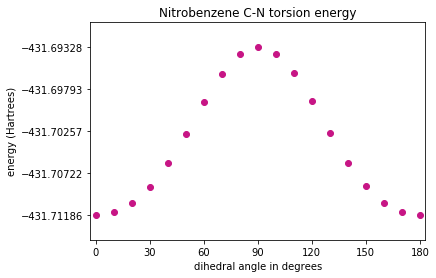

In [6]:
# find the energies from this optimization file
energy_values = plot_pes_energy()

# determine an appropriate range for plotting
energy_range = max(energy_values) - min(energy_values)

# plot the energies at each iteration
#plt.figure()
plt.scatter(phi, energy_values, color='MediumVioletRed')
plt.xlim(min(phi)-3, max(phi)+3)
plt.xticks(np.linspace(start=0, stop=180, num=7))
plt.ylim(top = max(energy_values) + energy_range*0.15, 
         bottom = min(energy_values) - energy_range*0.15)
plt.yticks(np.linspace(start=min(energy_values), stop=max(energy_values), num=5))
plt.xlabel("dihedral angle in degrees")
plt.ylabel("energy (Hartrees)")
plt.title("Nitrobenzene C-N torsion energy")
plt.show()
#plt.savefig(F'CN-torsion-hartrees.png')

**Bonus:** What if we'd like to get this PES in units of kJ/mol (and have the minimum be at zero)?

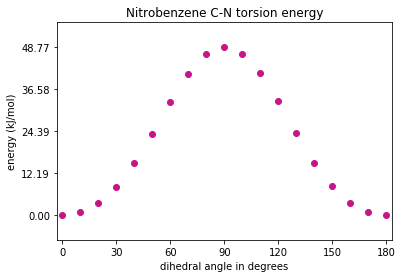

In [8]:
# do the unit conversion
energy_values_kJ = np.array(energy_values)*(1/3.8088e-4)
# and let's define the lowest energy to be zero
energy_values_kJ = energy_values_kJ - min(energy_values_kJ)

# determine the maximum energy (for setting y axes limits)
Emax = max(energy_values_kJ)

# plot the energies at each iteration
### note that plt.xticks() and plt.yticks()
### utilize np.linspace() in this solution
plt.scatter(phi, energy_values_kJ, color='MediumVioletRed')
plt.xlim(min(phi)-3, max(phi)+3)
plt.xticks(np.linspace(start=0, stop=180, num=7))
plt.ylim(-Emax*0.15, Emax*1.15)
plt.yticks(np.linspace(start=0, stop=Emax, num=5))
plt.xlabel("dihedral angle in degrees")
plt.ylabel("energy (kJ/mol)")
plt.title("Nitrobenzene C-N torsion energy")
plt.show()